In [1]:
from backtests import fetch_portfolio_states, start_backtest, wait_for_backtest, BacktestRequest
import matplotlib.pyplot as plt

In [5]:
def plot_portfolio_value(assets_states):
    portfolio_values = [state.assets.equityValue for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

In [6]:
def plot_num_of_positions(assets_states):
    portfolio_values = [len(state.assets.positions) for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Positions')
    plt.show()

In [14]:
request = BacktestRequest(
    strategy="PCA strategy with predictions",
    symbols=500,
    skip=500,
    use_predictor=False,
    avg_prediction_error=0.025
)

backtest_id = start_backtest(request)

In [15]:
wait_for_backtest(backtest_id)

In [16]:
portfolio_states = fetch_portfolio_states(backtest_id)

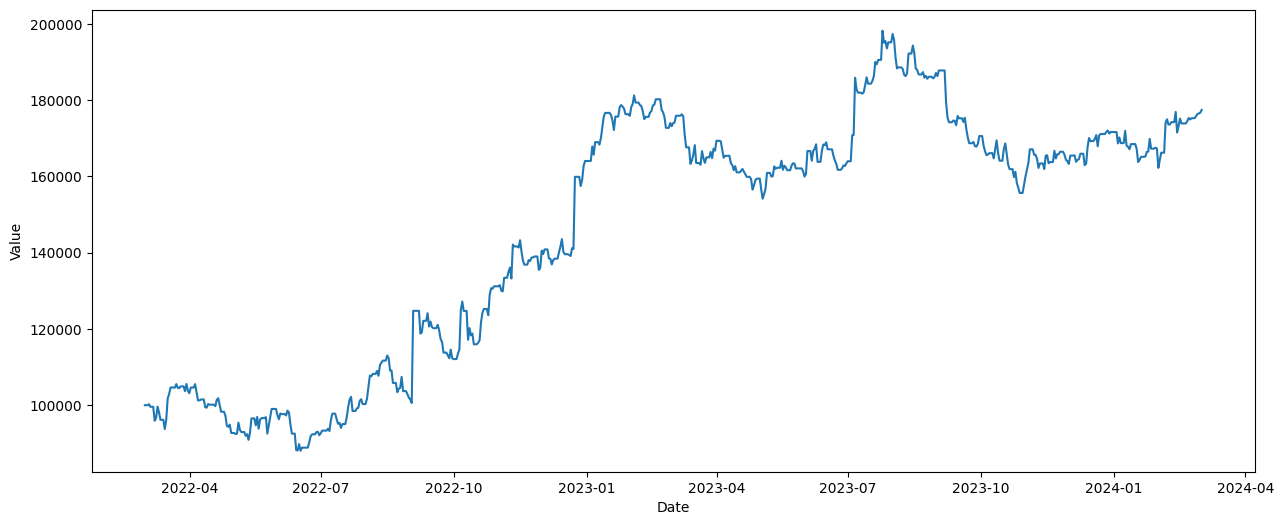

In [17]:
plot_portfolio_value(portfolio_states)

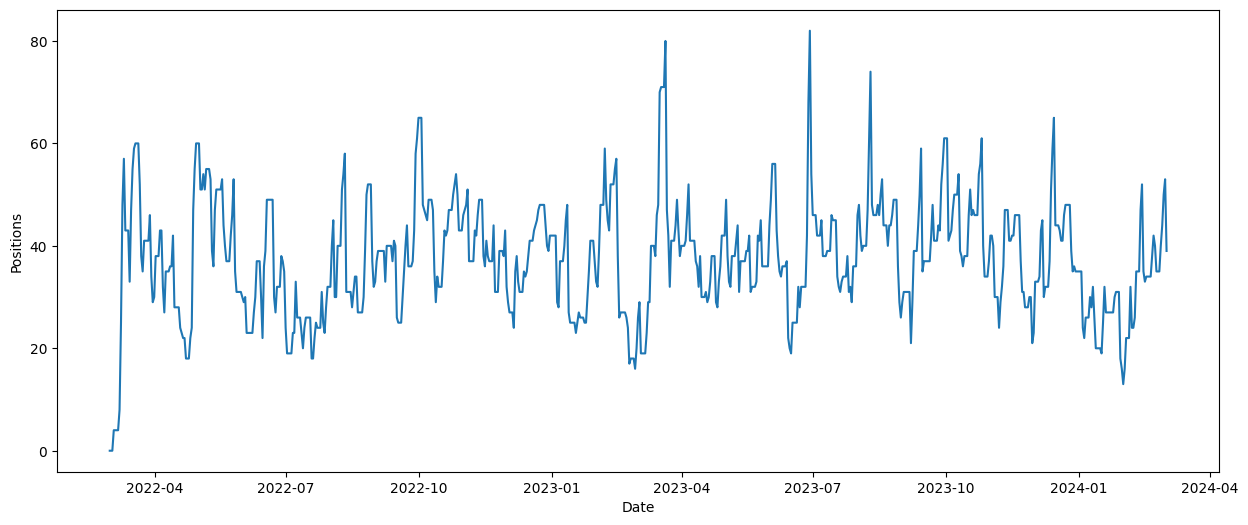

In [18]:
plot_num_of_positions(portfolio_states)